# Analysis 
## Random Forest 

In [153]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

In [184]:
df = pd.read_csv('../data/merged.csv')

In [185]:
df.shape

(21041, 66)

In [186]:
len(np.unique(df.ruid))

5623

In [187]:
df.head()

,ruid,visit_id,admit_date,discharge_date,stay_length,n_transfers,readmit_time,readmit_30d,sex,dob,...,gluc,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr
0,50135262,0,2007-02-08,2007-02-12,4 days 00:00:00.000000000,2,172 days 00:00:00.000000000,0,F,1949-09-20,...,138.0,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0,123.677830
1,50135262,1,2007-08-03,2007-08-06,3 days 00:00:00.000000000,3,22 days 00:00:00.000000000,1,F,1949-09-20,...,213.5,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0,89.505000
2,50135262,2,2007-08-28,2007-08-29,1 days 00:00:00.000000000,1,179 days 00:00:00.000000000,0,F,1949-09-20,...,266.0,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0,107.450000
3,50135262,3,2008-02-24,2008-02-28,4 days 00:00:00.000000000,2,44 days 00:00:00.000000000,0,F,1949-09-20,...,230.0,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0,73.010770
4,50135262,4,2008-04-12,2008-04-13,1 days 00:00:00.000000000,1,928 days 00:00:00.000000000,0,F,1949-09-20,...,162.0,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0,84.358415


In [234]:
df['age'] = pd.to_datetime(df['admit_date']) - pd.to_datetime(df['dob'])

In [235]:
df['age'] = df['age'].apply(lambda x: pd.to_timedelta(x).days/365.25)

In [236]:
df.head()

,ruid,visit_id,admit_date,discharge_date,stay_length,n_transfers,readmit_time,readmit_30d,sex,dob,...,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr,age
0,50135262,0,2007-02-08,2007-02-12,4 days 00:00:00.000000000,2,172 days 00:00:00.000000000,0,F,1949-09-20,...,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0,123.677830,57.385352
1,50135262,1,2007-08-03,2007-08-06,3 days 00:00:00.000000000,3,22 days 00:00:00.000000000,1,F,1949-09-20,...,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0,89.505000,57.867214
2,50135262,2,2007-08-28,2007-08-29,1 days 00:00:00.000000000,1,179 days 00:00:00.000000000,0,F,1949-09-20,...,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0,107.450000,57.935661
3,50135262,3,2008-02-24,2008-02-28,4 days 00:00:00.000000000,2,44 days 00:00:00.000000000,0,F,1949-09-20,...,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0,73.010770,58.428474
4,50135262,4,2008-04-12,2008-04-13,1 days 00:00:00.000000000,1,928 days 00:00:00.000000000,0,F,1949-09-20,...,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0,84.358415,58.559890


In [238]:
y = df.pop('readmit_30d')
X = df.drop(columns=['visit_id', 'admit_date', 'discharge_date', 'readmit_time',
                    'dob', 'dod'])

## Imputation

In [239]:
X.isnull().sum()

ruid                                              0
stay_length                                       0
n_transfers                                       0
sex                                               0
race                                              0
cpt_anesthesia                                    0
cpt_eval_manage                                   0
cpt_expired                                       0
cpt_medicine                                      0
cpt_modifier                                      0
cpt_path_lab                                      0
cpt_radiology                                     0
cpt_surgery                                       0
cpt_unknown                                       0
icd_dx_blood                                      0
icd_dx_circulatory                                0
icd_dx_congenital                                 0
icd_dx_digestive                                  0
icd_dx_endocrine                                  0
icd_dx_exter

***Simple imputation to start

In [240]:
X_imputed = X.fillna(X.mean())

## Coerce Stay Length

In [241]:
X_imputed['stay_length'] = X_imputed['stay_length'].apply(lambda x: pd.to_timedelta(x).days)

In [242]:
X_imputed.head()

,ruid,stay_length,n_transfers,sex,race,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,...,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr,age
0,50135262,4,2,F,W,0.0,6.0,4.0,16.0,9.0,...,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0,123.677830,57.385352
1,50135262,3,3,F,W,0.0,2.0,1.0,16.0,15.0,...,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0,89.505000,57.867214
2,50135262,1,1,F,W,0.0,3.0,0.0,7.0,4.0,...,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0,107.450000,57.935661
3,50135262,4,2,F,W,0.0,6.0,1.0,4.0,8.0,...,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0,73.010770,58.428474
4,50135262,1,1,F,W,0.0,1.0,1.0,2.0,3.0,...,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0,84.358415,58.559890


## Coerce Categories

In [243]:
X_dummy = pd.get_dummies(X_imputed)
X_dummy.drop(columns='ruid', inplace=True)
X_dummy.head()

,stay_length,n_transfers,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,...,sex_F,sex_M,sex_U,race_A,race_B,race_H,race_I,race_N,race_U,race_W
0,4,2,0.0,6.0,4.0,16.0,9.0,24.0,9.0,2.0,...,1,0,0,0,0,0,0,0,0,1
1,3,3,0.0,2.0,1.0,16.0,15.0,39.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0.0,3.0,0.0,7.0,4.0,13.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3,4,2,0.0,6.0,1.0,4.0,8.0,47.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
4,1,1,0.0,1.0,1.0,2.0,3.0,21.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,1


## Train-Validation-Test Split

In [244]:
# 80% train/validation, 20% testing
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(
                                            X_dummy, y, test_size=0.2, random_state=42)

X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

((16832, 67), (16832,), (4209, 67), (4209,))

In [245]:
# 60% training, 20% validation (which would be 75%/25% of previously created X_train/y_train)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
                                    X_train_val, y_train_val, test_size=0.25, random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((12624, 67), (12624,), (4208, 67), (4208,))

In [246]:
y_train.value_counts()/y_train.shape[0]

0    0.730909
1    0.269091
Name: readmit_30d, dtype: float64

In [247]:
y_valid.value_counts()/y_valid.shape[0]

0    0.731226
1    0.268774
Name: readmit_30d, dtype: float64

In [248]:
y_test.value_counts()/y_test.shape[0]

0    0.730577
1    0.269423
Name: readmit_30d, dtype: float64

## Preliminary Model

In [249]:
scorer = {'f1': make_scorer(f1_score)}

rf = RandomForestClassifier()

In [250]:
max_features = [5, 8, 10, 12, 15]
n_estimators = [25, 50, 100]

# Create the grid
parameter_grid = {'max_features': max_features, 
                  'n_estimators': n_estimators}

In [148]:
rf_cv = model_selection.GridSearchCV(estimator=rf, cv=5, n_jobs=3, param_grid=parameter_grid,
                                     scoring=scorer, refit='f1')

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_features': [5, 8, 10, 12, 15], 'n_estimators': [25, 50, 100]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score='warn',
       scoring={'f1': make_scorer(f1_score)}, verbose=0)

In [149]:
rf_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [150]:
rf_cv.best_score_

0.26410995813795013

In [151]:
predictions = rf_cv.best_estimator_.predict(X_valid)
f1_score(y_valid, predictions)

0.2774490466798159

In [154]:
roc_auc_score(y_valid, predictions)

0.5641935101047761

In [152]:
confusion_matrix(y_valid, predictions)

array([[2898,  179],
       [ 920,  211]])

In [251]:
rf = RandomForestClassifier(n_estimators=500, max_features=20)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [252]:
predictions = rf.predict(X_valid)
f1_score(y_valid, predictions)

0.2575107296137339

In [253]:
roc_auc_score(y_valid, predictions)

0.5654384502456404

In [254]:
def feature_importance(rf, train, pred_cols):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    predictors = train[pred_cols].columns
    X = train[pred_cols]

    # Print the feature ranking
    print("Feature ranking:")
    #for f in range(X.shape[1]): # all features
    for f in range(5): # top 5 only
        print("%d. %s (%f)" % (f + 1, predictors[indices[f]], importances[indices[f]]))
    
    return X, importances, std, predictors, indices

Feature ranking:
1. age (0.047420)
2. bmi (0.034783)
3. plt-ct (0.033671)
4. glubed (0.031773)
5. med_Antiemetics (0.031670)


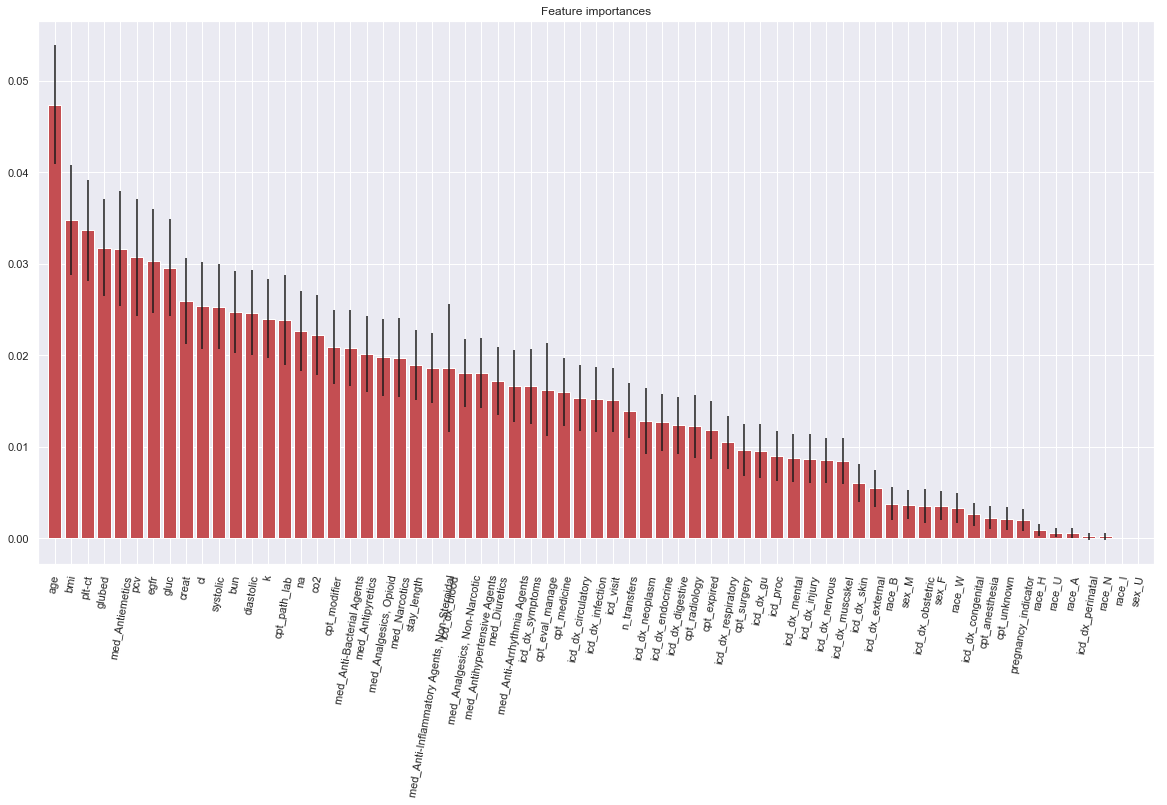

In [255]:
x, importances, std, predictors, indices = feature_importance(rf=rf, 
                                                                              train=X_train, 
                                                                              pred_cols=X_train.columns)

plt.figure(figsize=(20,10)); plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), predictors[indices], rotation=80); plt.xlim([-1, x.shape[1]])
plt.show()